In [1]:
import sys
import os

# 添加 factor_evaluation.pyd 所在的目录到系统路径
pyd_path = r"D:\MG\！internship\！4L CAPITAL\因子评估器"
sys.path.append(pyd_path)

# 导入模块
from factor_evaluation import FactorEvaluation
from factor_evaluation import DataService
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression

In [2]:
ds=DataService()
df=ds['ETHUSDT_15m_2020_2025']['2021-10-01':]

In [3]:
evaluator=FactorEvaluation(df=df,future_return_periods=10)

In [4]:
def adaptive_kdj_factor(df, volatility_window=20):
    # Calculate log returns safely
    returns = np.log(df['close']).diff()
    
    # Calculate rolling volatility with min_periods to avoid initial NaNs
    vol = returns.rolling(volatility_window, min_periods=1).std()
    
    # Handle any remaining NaNs/Infs robustly
    vol = vol.replace([np.inf, -np.inf], np.nan).ffill().bfill().fillna(0.01)
    
    # Convert to integer period between 5 and 20
    n_period = (vol * 100).clip(5, 20).astype(int)
    
    # Precompute rolling min/max for all required periods
    periods = list(range(5, 21))
    min_df = pd.DataFrame({p: df['low'].rolling(p, min_periods=1).min() for p in periods})
    max_df = pd.DataFrame({p: df['high'].rolling(p, min_periods=1).max() for p in periods})
    
    # Extract appropriate values using vectorized operations
    col_idx = (n_period - 5).values
    row_idx = np.arange(len(df))
    low_min = min_df.values[row_idx, col_idx]
    high_max = max_df.values[row_idx, col_idx]
    
    # Compute RSV safely
    denom = high_max - low_min
    rsv = 100 * (df['close'].values - low_min) / np.where(denom < 1e-8, np.nan, denom)
    rsv = pd.Series(rsv, index=df.index).fillna(50.0)  # Neutral value when denom≈0
    
    # Compute K-line (EMA of RSV)
    K = rsv.ewm(span=3, adjust=False, min_periods=1).mean()
    
    # Center using expanding mean without look-ahead bias
    mean_so_far = K.expanding().mean().shift(1).fillna(50.0)
    return K - mean_so_far

def optimize_weights(df, factors, target):
    # Create feature matrix X from factors
    X = pd.DataFrame({name: factor(df) for name, factor in factors.items()})
    y = target(df)
    # Remove rows with NaN in X or y
    valid_rows = X.notna().all(axis=1) & y.notna()
    X = X.loc[valid_rows]
    y = y.loc[valid_rows]
    # Check if there's enough data to fit the model
    if len(X) == 0:
        raise ValueError("No valid data remaining after removing NaN values.")
    model = LinearRegression()
    model.fit(X, y)
    return model.coef_

def macd(df, fast=12, slow=26, signal=9):
    # Calculate MACD, filling NaN with 0
    ema_fast = df['close'].ewm(span=fast, adjust=False).mean()
    ema_slow = df['close'].ewm(span=slow, adjust=False).mean()
    macd_line = ema_fast - ema_slow
    return macd_line.fillna(0)

def atr(df, period=14):
    # Calculate ATR, filling NaN with 0
    high_low = df['high'] - df['low']
    high_close = np.abs(df['high'] - df['close'].shift())
    low_close = np.abs(df['low'] - df['close'].shift())
    ranges = pd.concat([high_low, high_close, low_close], axis=1)
    true_range = np.max(ranges, axis=1)
    atr_value = true_range.rolling(period, min_periods=1).mean()
    return atr_value.fillna(0)

def improved_factor(df):
    # Original adaptive KDJ factor
    adaptive_kdj = adaptive_kdj_factor(df)
    
    # Buying pressure using turnover ratio, avoiding division by zero
    buy_pressure = df['taker_buy_turnover'] / df['turnover'].replace(0, np.nan)
    buy_pressure = buy_pressure.fillna(0)
    
    # Trend strength via MACD
    macd_diff = macd(df)
    
    # Volatility adjustment via ATR
    atr_value = atr(df)
    
    # Standardize components (handle NaN in standardization)
    standardized_adaptive_kdj = (adaptive_kdj - adaptive_kdj.mean()) / adaptive_kdj.std()
    standardized_buy_pressure = (buy_pressure - buy_pressure.mean()) / buy_pressure.std()
    standardized_macd_diff = (macd_diff - macd_diff.mean()) / macd_diff.std()
    standardized_atr = (atr_value - atr_value.mean()) / atr_value.std()
    
    # Handle NaN from standardization (if std is 0)
    standardized_adaptive_kdj = standardized_adaptive_kdj.fillna(0)
    standardized_buy_pressure = standardized_buy_pressure.fillna(0)
    standardized_macd_diff = standardized_macd_diff.fillna(0)
    standardized_atr = standardized_atr.fillna(0)
    
    # Define factors and target
    factors = {
        'adaptive_kdj': lambda df: standardized_adaptive_kdj,
        'buy_pressure': lambda df: standardized_buy_pressure,
        'macd_diff': lambda df: standardized_macd_diff,
        'atr': lambda df: -standardized_atr  # Negative ATR to penalize high volatility
    }
    target = lambda df: df['close'].pct_change(10).shift(-10)
    
    # Optimize weights based on historical data
    weights = optimize_weights(df, factors, target)
    
    # Combine factors with optimized weights
    combined_factor = sum(weight * factor(df) for weight, factor in zip(weights, factors.values()))
    
    # Final normalization to stabilize magnitude
    abs_mean = combined_factor.abs().rolling(50, min_periods=1).mean().clip(1e-5, None)
    normalized_factor = combined_factor / abs_mean
    
    return normalized_factor

In [5]:
evaluator.set_factor(
    factor_data_or_func=improved_factor,
    factor_name='improved_factor'
)


📊 单币种 (single) 详细评估结果:
--------------------------------------------------
🔗 相关性分析:
   IC (Pearson): 0.005678
   Rank_IC (Spearman): -0.004060
📊 信息比率:
   IR: -0.469507
   有效分组数: 10
📊 因子分布:
📋 数据概况:
   数据长度: 130379
   因子列: improved_factor
   收益率列: future_return
   未来收益周期: 10
--------------------------------------------------

🖼️  单币种 (single) 图片展示:
----------------------------------------
📊 显示分组分析图...


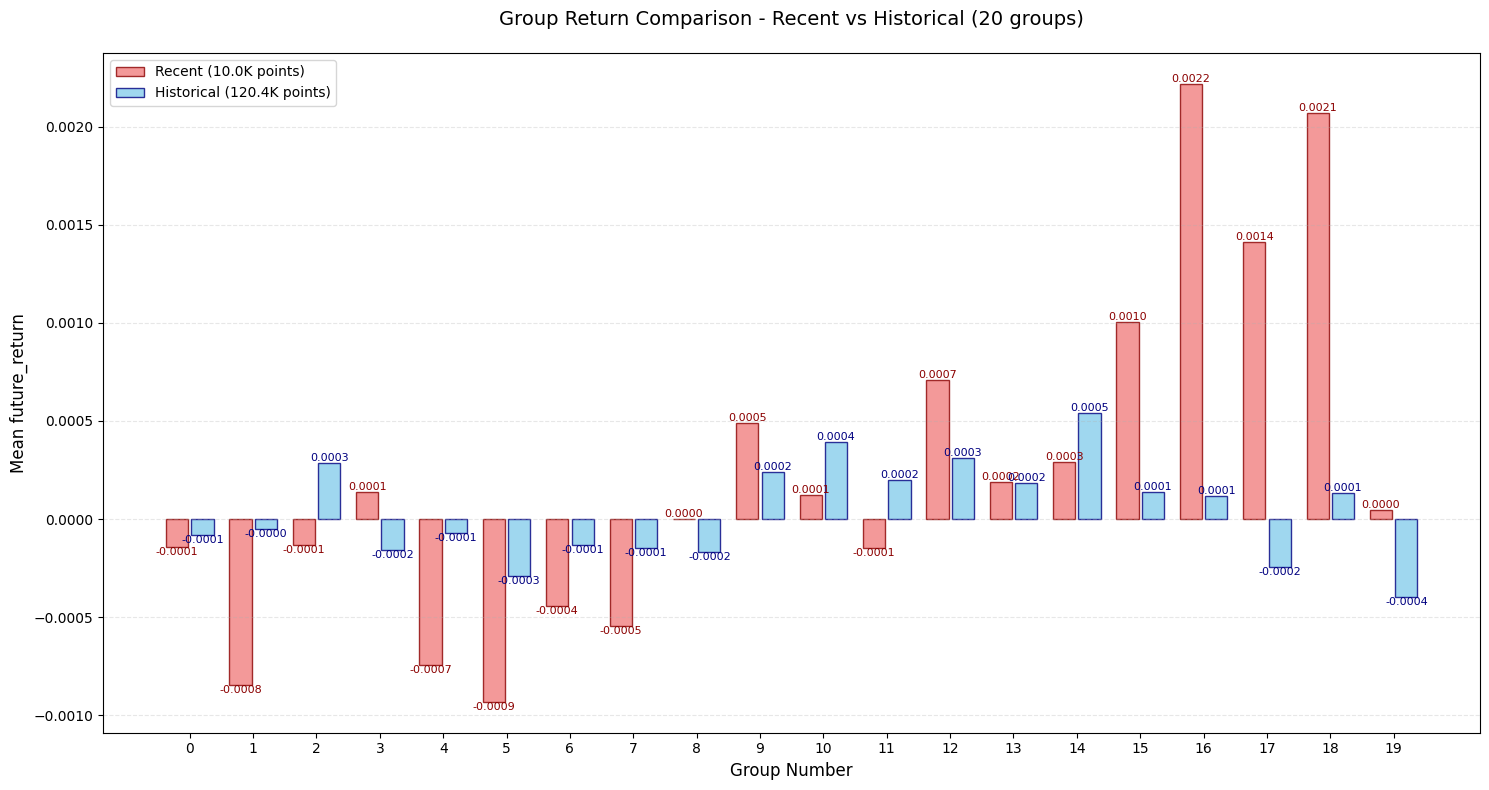

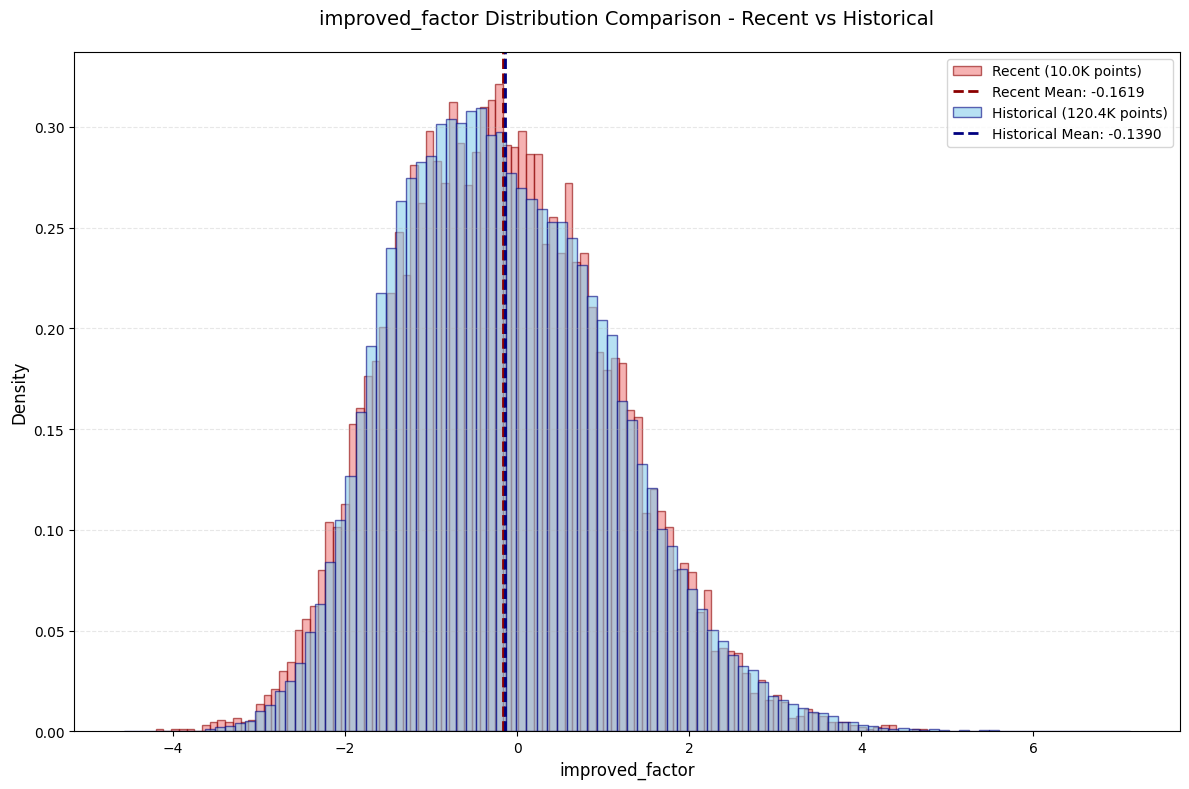

📈 显示因子分布图...
✅ 已显示 2 个图片
----------------------------------------


In [6]:
result=evaluator.run_full_evaluation(run_stationarity_test=False)